In [ ]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np
import pdb

import torch
import torch.nn.functional as F
import torch.optim as optim

from pygcn.utils import load_data, accuracy
from pygcn.models import GCN

# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--fastmode', action='store_true', default=False,
                    help='Validate during training pass.')
parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=200,
                    help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.01,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden units.')
parser.add_argument('--dropout', type=float, default=0.5,
                    help='Dropout rate (1 - keep probability).')

# args = parser.parse_args()
args = parser.parse_args(args=[])
args.cuda = not args.no_cuda and torch.cuda.is_available()

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Load data
adj, features, labels, idx_train, idx_val, idx_test = load_data()

# Model and optimizer
model = GCN(nfeat=features.shape[1],
            nhid=args.hidden,
            nclass=labels.max().item() + 1,
            dropout=args.dropout)
optimizer = optim.Adam(model.parameters(),
                       lr=args.lr, weight_decay=args.weight_decay)

if args.cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()


def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    if not args.fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
        model.eval()
        output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))

In [112]:
def test():
    model.eval()
    output = model(features, adj)
#     np.save('gcn_output', torch.softmax(output, 1).cpu().numpy())
    # import pdb; pdb.set_trace()
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])  # 1000 nodes
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))
    return torch.softmax(output, 1)

In [113]:
# Train model
t_total = time.time()
for epoch in range(args.epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Testing
output = test()

Epoch: 0001 loss_train: 0.2091 acc_train: 0.9857 loss_val: 0.6253 acc_val: 0.8100 time: 0.0058s
Epoch: 0002 loss_train: 0.1940 acc_train: 0.9857 loss_val: 0.6272 acc_val: 0.8100 time: 0.0050s
Epoch: 0003 loss_train: 0.2416 acc_train: 0.9857 loss_val: 0.6266 acc_val: 0.8133 time: 0.0049s
Epoch: 0004 loss_train: 0.2157 acc_train: 0.9571 loss_val: 0.6223 acc_val: 0.8133 time: 0.0054s
Epoch: 0005 loss_train: 0.2497 acc_train: 0.9786 loss_val: 0.6177 acc_val: 0.8100 time: 0.0051s
Epoch: 0006 loss_train: 0.2006 acc_train: 0.9857 loss_val: 0.6129 acc_val: 0.8200 time: 0.0054s
Epoch: 0007 loss_train: 0.1993 acc_train: 0.9929 loss_val: 0.6101 acc_val: 0.8200 time: 0.0054s
Epoch: 0008 loss_train: 0.2538 acc_train: 0.9500 loss_val: 0.6095 acc_val: 0.8167 time: 0.0054s
Epoch: 0009 loss_train: 0.2257 acc_train: 0.9714 loss_val: 0.6086 acc_val: 0.8167 time: 0.0055s
Epoch: 0010 loss_train: 0.2101 acc_train: 0.9786 loss_val: 0.6089 acc_val: 0.8167 time: 0.0055s
Epoch: 0011 loss_train: 0.2022 acc_train

In [12]:
def get_node_pos(cluster_label, mode='raw', predict=None):
    node_pos = {}
    if mode == 'raw':
        for label in set(cluster_label):
            node_pos.update(
                {label: np.argwhere(cluster_label == label).flatten().tolist()})
    elif mode == 'diff':
        assert predict is not None
        true = np.argwhere(cluster_label == predict).flatten().tolist()
        false = set(range(len(cluster_label))).difference(true)
        node_pos.update({'true': true, 'false': false})

    else:
        raise NotImplementedError(f'mode: {mode} unrecognized')

    return node_pos


# options = {"node_size": 40, "alpha": 0.8}


def plot_cluster(graph, node_pos, colors, options={"node_size": 40, "alpha": 0.8},  figsize=(8, 6), spring_k=0.15):
    pos = nx.spring_layout(graph, k=spring_k)
    from matplotlib.pyplot import figure
    figure(num=None, figsize=figsize, dpi=150, facecolor='w', edgecolor='k')
    for node_label in node_pos:
        nx.draw_networkx_nodes(
            graph, pos, nodelist=node_pos[node_label], node_color=colors[node_label], **options)
    nx.draw_networkx_edges(graph, pos, width=0.2, alpha=0.5)

In [13]:
adj  # normalized adj

tensor(indices=tensor([[   0,    8,   14,  ..., 1389, 2344, 2707],
                       [   0,    0,    0,  ..., 2707, 2707, 2707]]),
       values=tensor([0.1667, 0.1667, 0.0500,  ..., 0.2000, 0.5000, 0.2500]),
       device='cuda:0', size=(2708, 2708), nnz=13264, layout=torch.sparse_coo)

In [67]:
import networkx as nx
import scipy.sparse as sp
ori_adj = adj.to_dense().cpu().numpy()
ori_adj = np.where(ori_adj > 0, 1, 0)


sparse_adj = sp.csr_matrix(ori_adj)
graph = nx.from_scipy_sparse_matrix(sparse_adj)

np_labels = labels.cpu().numpy()

In [94]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels), preds


# def test():
model.eval()
output = model(features, adj)
# import pdb; pdb.set_trace()
loss_test = F.nll_loss(output[idx_test], labels[idx_test])
acc_test, preds = accuracy(
    output[idx_test], labels[idx_test])  # 1000 nodes
print("Test set results:",
      "loss= {:.4f}".format(loss_test.item()),
      "accuracy= {:.4f}".format(acc_test.item()))
# return preds

Test set results: loss= 1.8869 accuracy= 0.3090


In [ ]:
preds = test()

In [116]:
preds

tensor([[0.9807, 0.0015, 0.0079,  ..., 0.0014, 0.0034, 0.0026],
        [0.0171, 0.0435, 0.0083,  ..., 0.0129, 0.0591, 0.0265],
        [0.0061, 0.0067, 0.0032,  ..., 0.0061, 0.0066, 0.9658],
        ...,
        [0.0123, 0.0270, 0.0249,  ..., 0.8400, 0.0232, 0.0348],
        [0.0125, 0.8665, 0.0217,  ..., 0.0202, 0.0170, 0.0266],
        [0.9665, 0.0047, 0.0078,  ..., 0.0053, 0.0043, 0.0039]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [115]:
cpu_label = labels.cpu().numpy()
cpu_idx_test = idx_test.cpu().numpy()
true = np.argwhere(cpu_label[idx_test.tolist()] ==
                   preds.cpu().numpy()).flatten().tolist()
false = list(set(cpu_idx_test).difference(true))

Test set results: loss= 0.5887 accuracy= 0.8380


RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [ ]:
np.save('pyGCN_81.9', np.array(false))

In [17]:
# false.sort()
false[-10:]

[1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499]

In [31]:
false.__len__()

181

In [23]:
true = idx_test[np.argwhere(preds.cpu().numpy(
) == cpu_label[idx_test.tolist()]).flatten().tolist()].tolist()

false = list(set(idx_test.tolist()).difference(true))

len(false)

181

In [244]:
def plot_cluster(graph, node_pos, colors, pos_layout, options={"node_size": 40, "alpha": 0.8},  figsize=(8, 6), spring_k=0.15):

    from matplotlib.pyplot import figure
    figure(num=None, figsize=figsize, dpi=150, facecolor='w', edgecolor='k')
    for node_label in node_pos:
        nx.draw_networkx_nodes(
            graph, pos, nodelist=node_pos[node_label], node_color=colors[node_label], **options)
    nx.draw_networkx_edges(graph, pos, width=0.2, alpha=0.5)



In [23]:
import networkx as nx
cora_graph = adj.cpu().to_dense().numpy()

cora_graph = nx.Graph(cora_graph)

list(cora_graph[508])

[317, 417, 508, 523, 2326]

In [ ]:
def bfs_queue(graph: nx.Graph, root, max_level=3, level=0):
    import collections
    queue, res = collections.deque([(root, 0)]), []
    nodes = set(res)
    while queue:
        node, level = queue.popleft()
        if level > max_level:
            break
        if node not in nodes:
            nodes.update([node])
            if len(res) < level+1:
                res.insert(level, [])
            res[level].append(node)
        for neighbor in list(graph[node]):
            try:
                if neighbor not in sum(res,[]):
                    queue.append([neighbor, level+1])
            except:
                import pdb; pdb.set_trace()
    return res, list(nodes)

def statistics(graph, nodes, level=6):
    from texttable import Texttable
    from tqdm import tqdm
    table = Texttable()
    table.set_deco(Texttable.HEADER)
    results = {}
#     table.set_cols_dtype(['t',  # text
#                               'f',  # float (decimal)
#                               'e',  # float (exponent)
#                               'i',  # integer
#                               'a']) # automatic
    stat = [['Node']]
    stat[0].extend([f'{i}-hop' for i in range(1,level+1)])
    for node in tqdm(nodes):
        res, nodes = bfs_queue(cora_graph, node, level)
        row = [node]
        for hop in range(1, level+1):
            if len(res) < hop+1:
                row.append(0)
            else:
                row.append(len(res[hop]))
        stat.append(row)
        results[node] = (res, nodes)
    table.add_rows(stat)
    print(table.draw())
    return results  
def get_colors(label_number: int, mode: str):
    import randomcolor
    rand_color = randomcolor.RandomColor()
    if mode == 'diff':
        colors = {'train': 'grey', 'pred_train': 'green', 'pred_false': 'r'}
    elif mode == 'raw':
        colors = dict([(i, j) for i, j in enumerate(
            rand_color.generate(count=label_number))])
    elif mode == 'train_test':
        colors = {'train': 'grey', 'test': 'black'}
    elif mode == 'error':
        colors = dict([(i, j) for i, j in enumerate(
            rand_color.generate(count=label_number))])
        colors.update({'root': 'black'})
    else:
        raise NotImplementedError
    return colors

from typing import Dict, Tuple, List, Sequence, Optional
def get_node_pos(labels: Optional[np.ndarray] = None, sg_nodes: List = None, idx_test: Optional[List] = None, mode='raw', predict: Optional[np.ndarray] = None) -> Dict:
    '''
    1. get the whole graph: raw
    2. train and test node
    3. right and wrong node
    '''
    if type(labels) is torch.Tensor:
        labels = labels.cpu().numpy()
    if type(predict) is torch.Tensor:
        predict = predict.cpu().numpy()

    node_pos = {}
    # np.argwhere(labels == label).flatten().tolist()})
    if mode == 'raw':
        if sg_nodes is not None:
            for label in set(labels[sg_nodes]):
                node_pos.update(
                    {label: [node for node in sg_nodes if labels[node] == label]})
        else:
            for label in set(labels):
                node_pos.update(
                    {label: np.argwhere(labels == label).flatten().tolist()})
    elif mode == 'error':
        root = sg_nodes[0]
        for label in set(labels[sg_nodes]):
            node_pos.update(
                {label: [node for node in sg_nodes if labels[node] == label]})
        print(node_pos)
        node_pos.update({'root': [root]})
                            
    elif mode == 'train_test':
        assert idx_test is not None and sg_nodes is not None
        test_sg_nodes = list(set(sg_nodes).intersection(idx_test))
        train_sg_nodes = list(set(sg_nodes).difference(test_sg_nodes))
        node_pos.update({'train': train_sg_nodes, 'test': test_sg_nodes})
        pass

    elif mode == 'diff':
        assert predict is not None and sg_nodes is not None and idx_test is not None
        test_sg_nodes = list(set(sg_nodes).intersection(idx_test))
        train_sg_nodes = list(set(sg_nodes).difference(test_sg_nodes))
        true = list(set(idx_test[np.argwhere(
            labels[idx_test] == predict).flatten().tolist()]).intersection(test_sg_nodes))
        false = list(set(test_sg_nodes).difference(true))
        node_pos.update(
            {'train': train_sg_nodes, 'pred_true': true, 'pred_false': false})

    else:
        raise NotImplementedError(f'mode: {mode} unrecognized')

    return node_pos

def plot_cluster(graph, node_pos, colors, pos, options={"node_size": 40, "alpha": 0.8},  figsize=(8, 6), spring_k=0.15, labels=None, border_edge_list=None):
    from matplotlib.pyplot import figure
    figure(num=None, figsize=figsize, dpi=150, facecolor='w', edgecolor='k')
    for node_label in node_pos:
        nx.draw_networkx_nodes(
            graph, pos, nodelist=node_pos[node_label], node_color=colors[node_label], **options)
    nx.draw_networkx_edges(graph, pos, width=0.2, alpha=0.5)
    if labels:
        nx.draw_networkx_labels(graph, pos, labels, font_size=5)
    if border_edge_list:
        nx.draw_networkx_edges(graph,pos,edgelist=border_edge_list,width=1,alpha=0.5,edge_color="b")
def get_1hop_neighbors_edges(adj, node):
    res = np.argwhere(adj[node]).flatten().tolist()
    res.remove(node)
    edge_list = [(node, i) for i in res]
    return res, edge_list
def one_hop_n_class(node, labels, adj):
    one_hop_n = np.argwhere(ori_adj[node]).flatten().tolist()
    neighbor_class = {i:labels[i] for i in one_hop_n}
    node_label = labels[node]
    from collections import Counter
    count = Counter(labels[one_hop_n])
    length = list(count.elements()).__len__()
    for ele in count:
        count[ele] = f'{count[ele]/length*100:.1f}%'
    return str(count), neighbor_class

In [41]:
sp_adj = torch.sparse_coo(adj)
sp_adj

TypeError: 'torch.layout' object is not callable

In [34]:
pygcn_only_node_info = statistics(cora_graph, false[:2])


100%|██████████| 2/2 [00:02<00:00,  1.40s/it]

Node   1-hop   2-hop   3-hop   4-hop   5-hop   6-hop
500    4       10      177     257     470     630  
501    4       9       175     314     558     622  


In [38]:
class_colors = get_colors(features.shape[1], 'error')
info = pygcn_only_node_info

In [39]:
error_case = 501
hop = 4
sub_node = sum(
    [node_list for node_list in info[error_case][0][:hop]], [])
sub_node[0]
error_graph = cora_graph.subgraph(sub_node)

labels = {error_case: 'error'}
border_edge = get_1hop_neighbors_edges(adj, error_case)[1]
# border_edge

RuntimeError: Didn't find kernel to dispatch to for operator 'aten::nonzero'. Tried to look up kernel for dispatch key 'SparseCUDATensorId'. Registered dispatch keys are: [CUDATensorId, CPUTensorId, VariableTensorId]

In [123]:
pos = nx.spring_layout(error_graph, k=0.15)
%matplotlib inline

/home/v-yulan/.conda/envs/py37/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


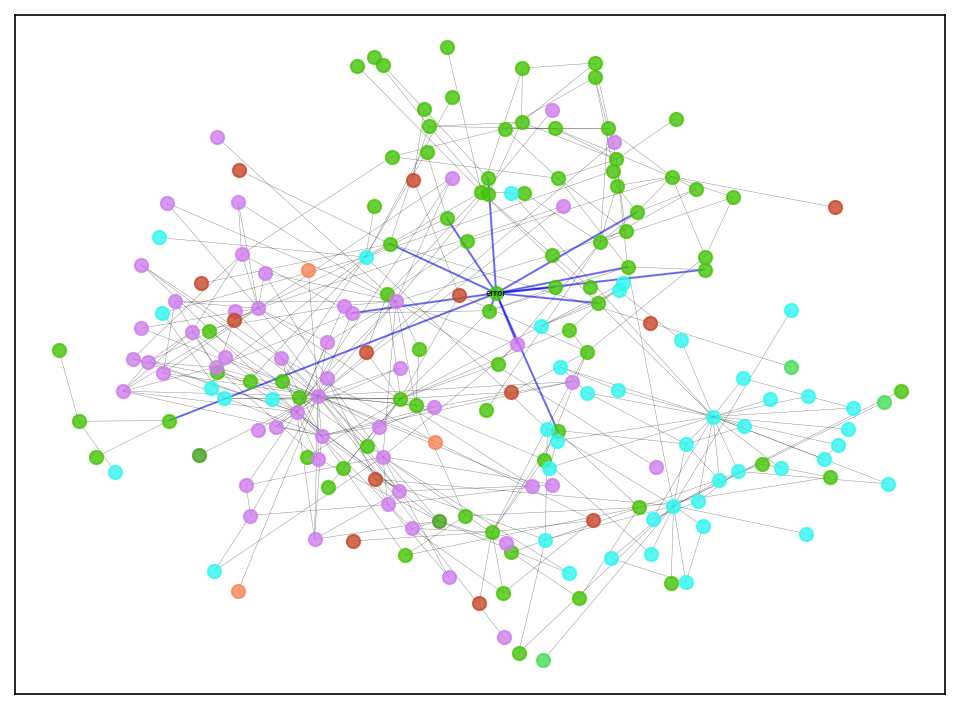

In [124]:
class_node_pos = get_node_pos(np_labels, sub_node, idx_test.cpu().numpy(), mode='raw')
plot_cluster(error_graph, class_node_pos, class_colors, pos,
             labels=labels, border_edge_list=border_edge)

In [118]:
labels.shape

torch.Size([2708])

In [124]:
labels[:10]

tensor([0, 3, 6, 6, 2, 2, 5, 0, 0, 5], device='cuda:0')

In [123]:
adj[2707]

tensor(indices=tensor([[ 774, 1389, 2344, 2707]]),
       values=tensor([0.2500, 0.2500, 0.2500, 0.2500]),
       device='cuda:0', size=(2708,), nnz=4, layout=torch.sparse_coo)